In [1]:
#@title Import and set ups{ display-mode: "form" }

%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import numpy as np
import tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

import subprocess
import pymongo
import motor.motor_asyncio
import bson
import bson.json_util
from bson.codec_options import CodecOptions
from bson.raw_bson import RawBSONDocument

import datetime
import time
import os

from scipy import interpolate

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds

import multiprocessing as mp

import gc

from numpy.random import default_rng

tf.enable_v2_behavior()
#tf.config.experimental.enable_tensor_float_32_execution(False)
print("TensorFloat-32: " + str(tf.config.experimental.tensor_float_32_execution_enabled()))

TensorFloat-32: True


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [4]:
exchange = "coinbasepro"
#exchange = "bitmex"
#exchange = "gdax"
#exchange = "kraken"
orderbook_path = f"orderbook_scaled_{exchange}"

In [5]:
orderbook_table = pq.read_table(f'/data/{orderbook_path}.parquet')
orderbook_df = orderbook_table.to_pandas()

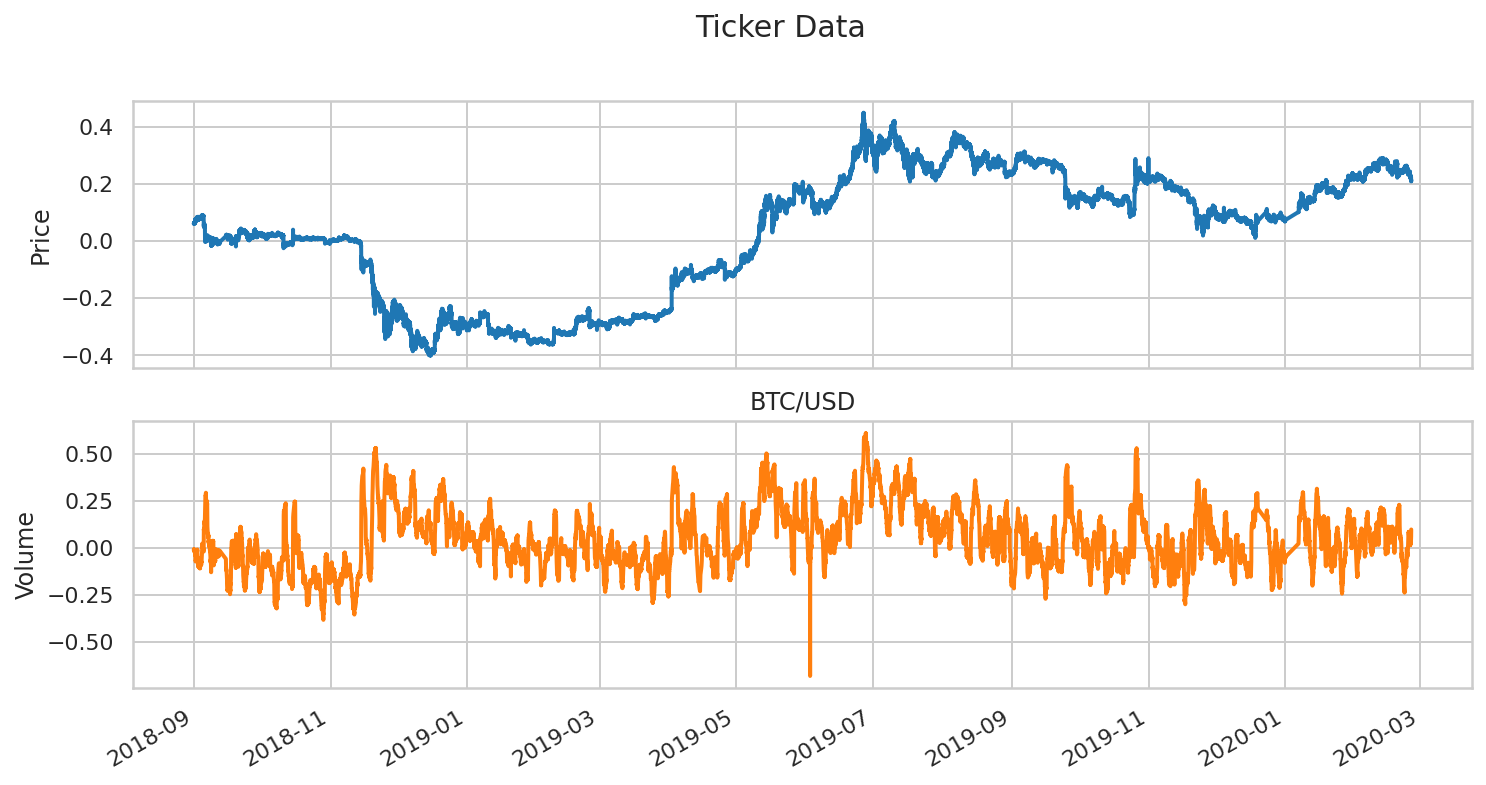

In [6]:
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(orderbook_df.index, orderbook_df.Price, lw=2, label="training data")
ax.set_ylabel("Price")

ax = fig.add_subplot(2, 1, 2)

ax.plot(orderbook_df.index, orderbook_df.Volume, lw=2, label="training data", c=c2)
ax.set_ylabel("Volume")
ax.set_title("BTC/USD")
fig.suptitle("Ticker Data",
             fontsize=15)
fig.autofmt_xdate()

In [7]:
orderbook_df

,Price,Volume,-0.000000500000,-0.000000601132,-0.000000722720,-0.000000868900,-0.000001044648,-0.000001255943,-0.000001509976,-0.000001815390,...,0.000952730359,0.001145433826,0.001377114352,0.001655655607,0.001990535853,0.002393150462,0.002877199687,0.003459154855,0.004158818856,0.005000000000
2018-09-01 00:00:05.311,0.060298,-0.008501,-1.0,-1.000000,0.366702,-0.243579,-0.378473,-0.368778,-0.359083,-0.349387,...,0.336916,0.389931,0.349751,0.318557,0.382015,0.357203,0.369771,0.450971,-1.0,-1.0
2018-09-01 00:00:35.284,0.060297,-0.008501,-1.0,-1.000000,0.393788,-0.190507,-0.225381,-0.215686,-0.205991,-0.196296,...,0.267534,0.408540,0.350390,0.319569,0.403683,0.358004,0.370131,0.365658,-1.0,-1.0
2018-09-01 00:01:04.970,0.060298,-0.008501,-1.0,-1.000000,0.460801,0.275965,0.285645,0.295340,0.305035,0.314730,...,-0.055038,0.112686,0.264262,0.359787,0.400802,0.369547,0.398341,0.444336,-1.0,-1.0
2018-09-01 00:01:40.193,0.061071,-0.008501,-1.0,-1.000000,0.463231,0.038117,0.046331,0.056026,0.065721,0.075416,...,0.137283,0.393280,0.269899,0.374977,0.383630,0.410064,0.399178,-1.000000,-1.0,-1.0
2018-09-01 00:02:15.602,0.061071,-0.008501,-1.0,-1.000000,0.428290,0.037451,0.046379,0.056074,0.065769,0.075464,...,0.366069,0.352843,0.346273,0.374950,0.387078,0.378196,-1.000000,-1.000000,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-26 02:46:03.694,0.214348,0.097036,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.435687,0.259608,0.456857,0.413994,0.407310,0.312603,-1.000000,-1.000000,-1.0,-1.0
2020-02-26 02:46:33.837,0.214833,0.097036,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.320040,0.384688,0.382834,0.447527,0.421526,0.443047,-1.000000,-1.000000,-1.0,-1.0
2020-02-26 02:47:02.991,0.214824,0.097036,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.288242,0.379237,0.345939,0.379853,0.404033,0.485482,-1.000000,-1.000000,-1.0,-1.0
2020-02-26 02:47:33.275,0.215094,0.097036,-1.0,0.425374,-0.006984,0.002712,0.012407,0.022102,0.031797,0.041492,...,0.355501,0.390026,0.369412,0.481740,0.410387,0.409763,-1.000000,-1.000000,-1.0,-1.0


In [8]:
inputs = orderbook_df.columns
input_seq_len = 90
output_seq_len = 10
n_in_features = len(inputs)
n_out_features = 1
batch_size = 128
cellsize=128

In [9]:
def create_model(lstm_layers, n_in_features, n_out_features, bidirectional=False,cudnn=True,twolayerout=True, activation_out=None):
    
    n_layers = len(lstm_layers)
    
    ## Encoder
    encoder_inputs = layers.Input(name="encoder_input", shape=(None, n_in_features))
    if cudnn:
        encoder_layers = [layers.LSTM(hidden_dim, return_sequences=(i!=(n_layers-1)), return_state=True, name=f"encoder_lstm_{i}") for i, hidden_dim in enumerate(lstm_layers)]        
    else:
        encoder_layers = [layers.LSTMCell(hidden_dim) for hidden_dim in lstm_layers]
    
    if bidirectional:
        if cudnn:
            bi_encoder_layers = [layers.Bidirectional(encoder_layer, name=f"bidirectional_lstm_{i}") for i, encoder_layer in enumerate(encoder_layers)]
            encoder_outputs_and_states = bi_encoder_layers[0](encoder_inputs)
            bi_encoder_states = encoder_outputs_and_states[1:]
            for encoder_layer in bi_encoder_layers[1:]:
                encoder_outputs_and_states = encoder_layer(encoder_outputs_and_states)
                bi_encoder_states.extend(encoder_outputs_and_states[1:])
            print(bi_encoder_states)
            encoder_states = []
            for i in range(int(len(bi_encoder_states)/4)):
                temp = [
                    layers.concatenate([bi_encoder_states[4*i],bi_encoder_states[4*i+2]], axis=-1, name=f"concatenate_hidden_{i}"),
                    layers.concatenate([bi_encoder_states[4*i+1],bi_encoder_states[4*i+3]], axis=-1, name=f"concatenate_cell_{i}")
                ]
                encoder_states.append(temp)        
        else:
            encoder = layers.Bidirectional(layers.RNN(encoder_layers, return_state=True, name="encoder_lstm"), name="bidirectional_lstm")
            encoder_outputs_and_states = encoder(encoder_inputs)
            bi_encoder_states = encoder_outputs_and_states[1:]
            print(bi_encoder_states)
            encoder_states = []
            for i in range(int(len(bi_encoder_states)/2)):
                temp = [
                    layers.concatenate([bi_encoder_states[i][0],bi_encoder_states[n_layers + i][0]], axis=-1, name=f"concatenate_hidden_{i}"),
                    layers.concatenate([bi_encoder_states[i][1],bi_encoder_states[n_layers + i][1]], axis=-1, name=f"concatenate_cell_{i}")
                ]
                encoder_states.append(temp)        
    else:  
        if cudnn:
            encoder_outputs_and_states = encoder_layers[0](encoder_inputs)
            encoder_states = [encoder_outputs_and_states[1:]]
            for encoder_layer in encoder_layers[1:]:
                encoder_outputs_and_states = encoder_layer(encoder_outputs_and_states)
                encoder_states.append(encoder_outputs_and_states[1:])
        else:
            encoder = layers.RNN(encoder_layers, return_state=True, name="encoder_lstm")
            encoder_outputs_and_states = encoder(encoder_inputs)
            encoder_states = encoder_outputs_and_states[1:]
    
    ## Decoder
    decoder_inputs = layers.Input(name="decoder_input", shape=(None, n_out_features))

    if cudnn:
        if bidirectional:
            decoder_layers = [layers.LSTM(hidden_dim*2, return_sequences=True, return_state=True, name=f"decoder_lstm_{i}") for i, hidden_dim in enumerate(lstm_layers)]
        else:
            decoder_layers = [layers.LSTM(hidden_dim, return_sequences=True, return_state=True, name=f"decoder_lstm_{i}") for i, hidden_dim in enumerate(lstm_layers)]

        print(encoder_states)
        decoder_outputs_and_states = decoder_layers[0](decoder_inputs, initial_state=encoder_states[0])
        decoder_outputs = decoder_outputs_and_states[0]
        for i, decoder_layer in enumerate(decoder_layers[1:]):
            decoder_outputs_and_states = decoder_layer(decoder_outputs, initial_state=encoder_states[i+1])
            decoder_outputs = decoder_outputs_and_states[0]
        print(decoder_outputs)
    else:
        if bidirectional:
            decoder_cells = [layers.LSTMCell(hidden_dim*2) for hidden_dim in lstm_layers]
        else:
            decoder_cells = [layers.LSTMCell(hidden_dim) for hidden_dim in lstm_layers]
        
        decoder_lstm = layers.RNN(decoder_cells, return_sequences=True, return_state=True, name="decoder_lstm")

        print(encoder_states)
        decoder_outputs_and_states = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_outputs = decoder_outputs_and_states[0]

    if twolayerout:
        if bidirectional:
            decoder_dense = layers.Dense(lstm_layers[-1]*2, name="dense_layer", activation=activation_out) 
        else:
            decoder_dense = layers.Dense(lstm_layers[-1], name="dense_layer", activation=activation_out) 
        decoder_dense_out_outputs = decoder_dense(decoder_outputs)
        decoder_dense_out = layers.Dense(n_out_features, name="dense_layer_out", activation=activation_out) 
        decoder_outputs = decoder_dense_out(decoder_dense_out_outputs)
    else:
        decoder_dense_out = layers.Dense(n_out_features, name="dense_layer_out", activation=activation_out) 
        decoder_outputs = decoder_dense_out(decoder_outputs)
    
    model = models.Model([encoder_inputs,decoder_inputs], decoder_outputs)
    return model

[[<tf.Tensor 'encoder_lstm_0/PartitionedCall:2' shape=(None, 128) dtype=float32>, <tf.Tensor 'encoder_lstm_0/PartitionedCall:3' shape=(None, 128) dtype=float32>]]
Tensor("decoder_lstm_0/PartitionedCall:1", shape=(None, None, 128), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None, 104)]  0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
encoder_lstm_0 (LSTM)           [(None, 128), (None, 119296      encoder_input[0][0]              
_______________________________________

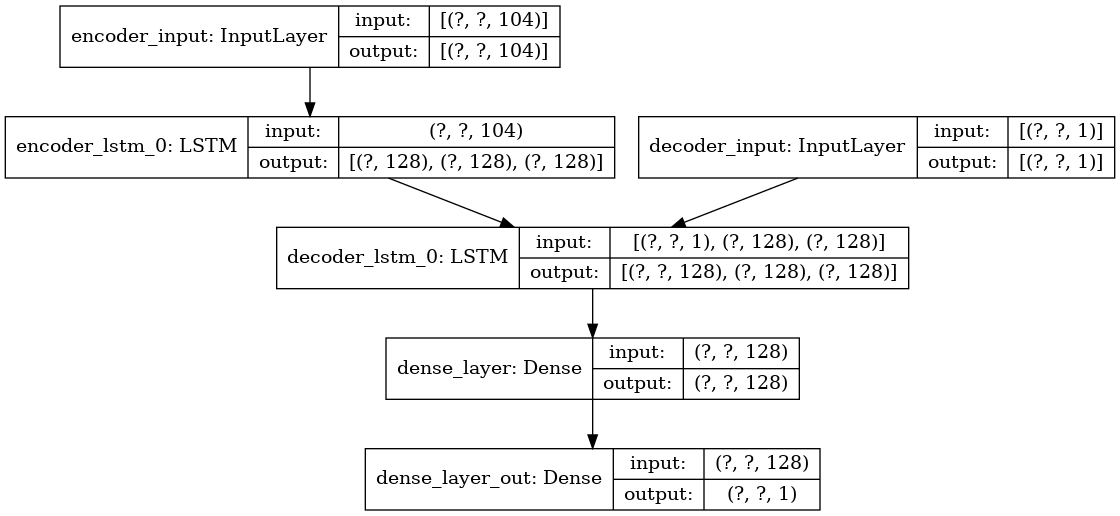

In [10]:
model_1 = create_model(lstm_layers=[cellsize], n_in_features=n_in_features, n_out_features=n_out_features, bidirectional=False,cudnn=True)
model_1.summary()
keras.utils.plot_model(model_1, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96)

[[<tf.Tensor 'encoder_lstm_0/PartitionedCall_1:2' shape=(None, 128) dtype=float32>, <tf.Tensor 'encoder_lstm_0/PartitionedCall_1:3' shape=(None, 128) dtype=float32>], [<tf.Tensor 'encoder_lstm_1/PartitionedCall:2' shape=(None, 128) dtype=float32>, <tf.Tensor 'encoder_lstm_1/PartitionedCall:3' shape=(None, 128) dtype=float32>]]
Tensor("decoder_lstm_1/PartitionedCall:1", shape=(None, None, 128), dtype=float32)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None, 104)]  0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None, 1)]    0                                            
_______________________________________________________________________

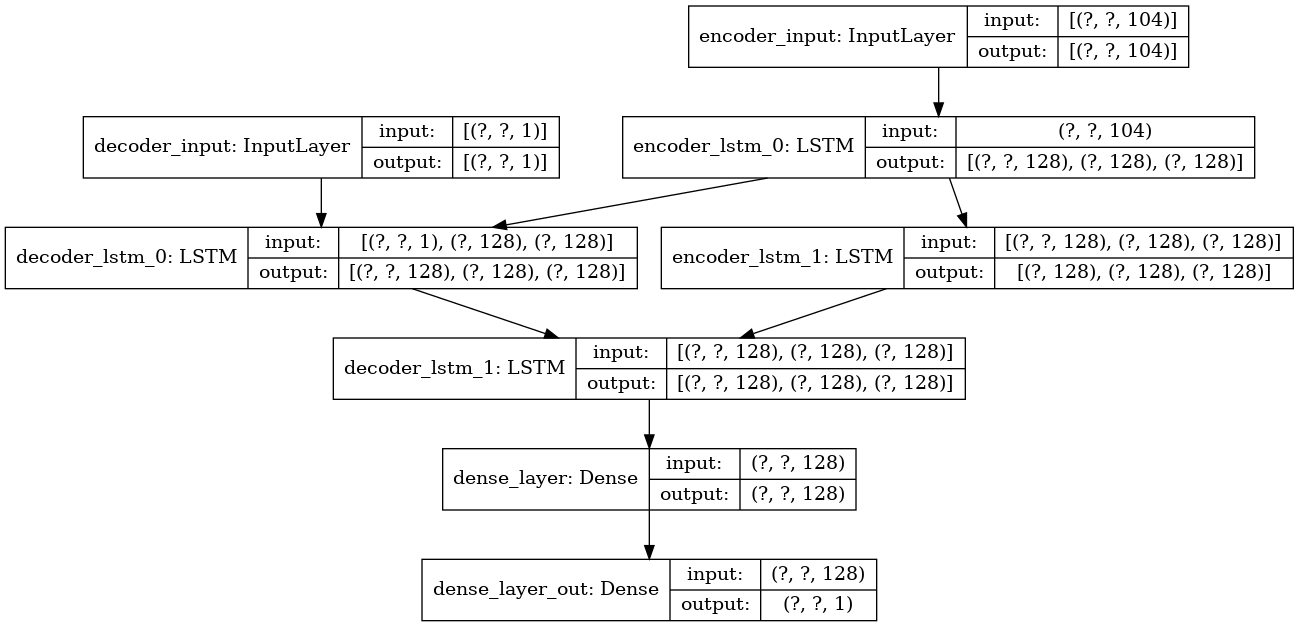

In [11]:
model_2 = create_model(lstm_layers=[cellsize,cellsize],n_in_features=n_in_features, n_out_features=n_out_features, bidirectional=False,cudnn=True)
model_2.summary()
keras.utils.plot_model(model_2, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96)

[<tf.Tensor 'bidirectional_lstm_0/forward_encoder_lstm_0/PartitionedCall:2' shape=(None, 128) dtype=float32>, <tf.Tensor 'bidirectional_lstm_0/forward_encoder_lstm_0/PartitionedCall:3' shape=(None, 128) dtype=float32>, <tf.Tensor 'bidirectional_lstm_0/backward_encoder_lstm_0/PartitionedCall:2' shape=(None, 128) dtype=float32>, <tf.Tensor 'bidirectional_lstm_0/backward_encoder_lstm_0/PartitionedCall:3' shape=(None, 128) dtype=float32>]
[[<tf.Tensor 'concatenate_hidden_0/concat:0' shape=(None, 256) dtype=float32>, <tf.Tensor 'concatenate_cell_0/concat:0' shape=(None, 256) dtype=float32>]]
Tensor("decoder_lstm_0/PartitionedCall_2:1", shape=(None, None, 256), dtype=float32)
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None, 104)]  0                                            
__

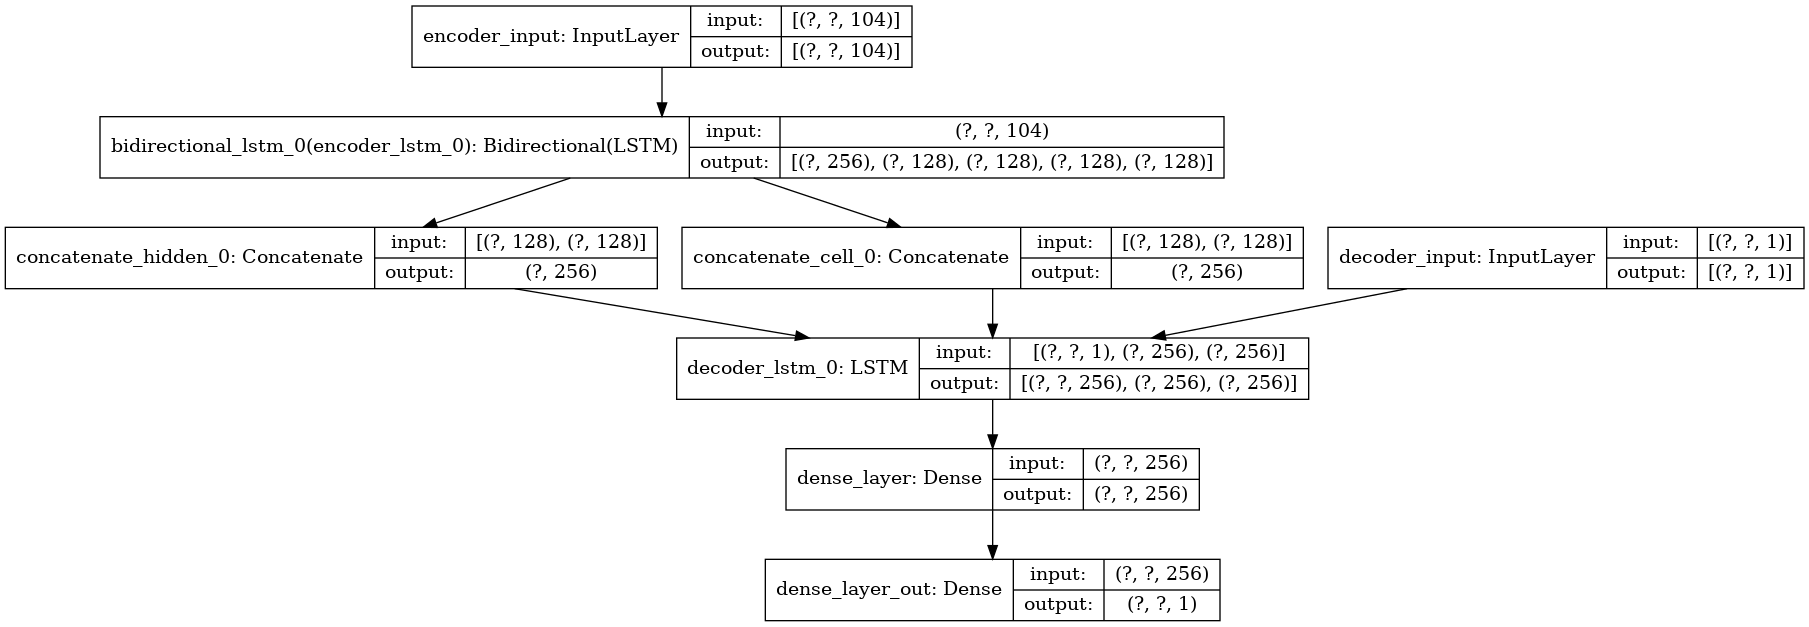

In [12]:
model_3 = create_model(lstm_layers=[cellsize],n_in_features=n_in_features, n_out_features=n_out_features, bidirectional=True)
model_3.summary()
keras.utils.plot_model(model_3, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96)

[<tf.Tensor 'bidirectional_lstm_0/forward_encoder_lstm_0/PartitionedCall_1:2' shape=(None, 128) dtype=float32>, <tf.Tensor 'bidirectional_lstm_0/forward_encoder_lstm_0/PartitionedCall_1:3' shape=(None, 128) dtype=float32>, <tf.Tensor 'bidirectional_lstm_0/backward_encoder_lstm_0/PartitionedCall_1:2' shape=(None, 128) dtype=float32>, <tf.Tensor 'bidirectional_lstm_0/backward_encoder_lstm_0/PartitionedCall_1:3' shape=(None, 128) dtype=float32>, <tf.Tensor 'bidirectional_lstm_1/forward_encoder_lstm_1/PartitionedCall:2' shape=(None, 128) dtype=float32>, <tf.Tensor 'bidirectional_lstm_1/forward_encoder_lstm_1/PartitionedCall:3' shape=(None, 128) dtype=float32>, <tf.Tensor 'bidirectional_lstm_1/backward_encoder_lstm_1/PartitionedCall:2' shape=(None, 128) dtype=float32>, <tf.Tensor 'bidirectional_lstm_1/backward_encoder_lstm_1/PartitionedCall:3' shape=(None, 128) dtype=float32>]
[[<tf.Tensor 'concatenate_hidden_0/concat_1:0' shape=(None, 256) dtype=float32>, <tf.Tensor 'concatenate_cell_0/con

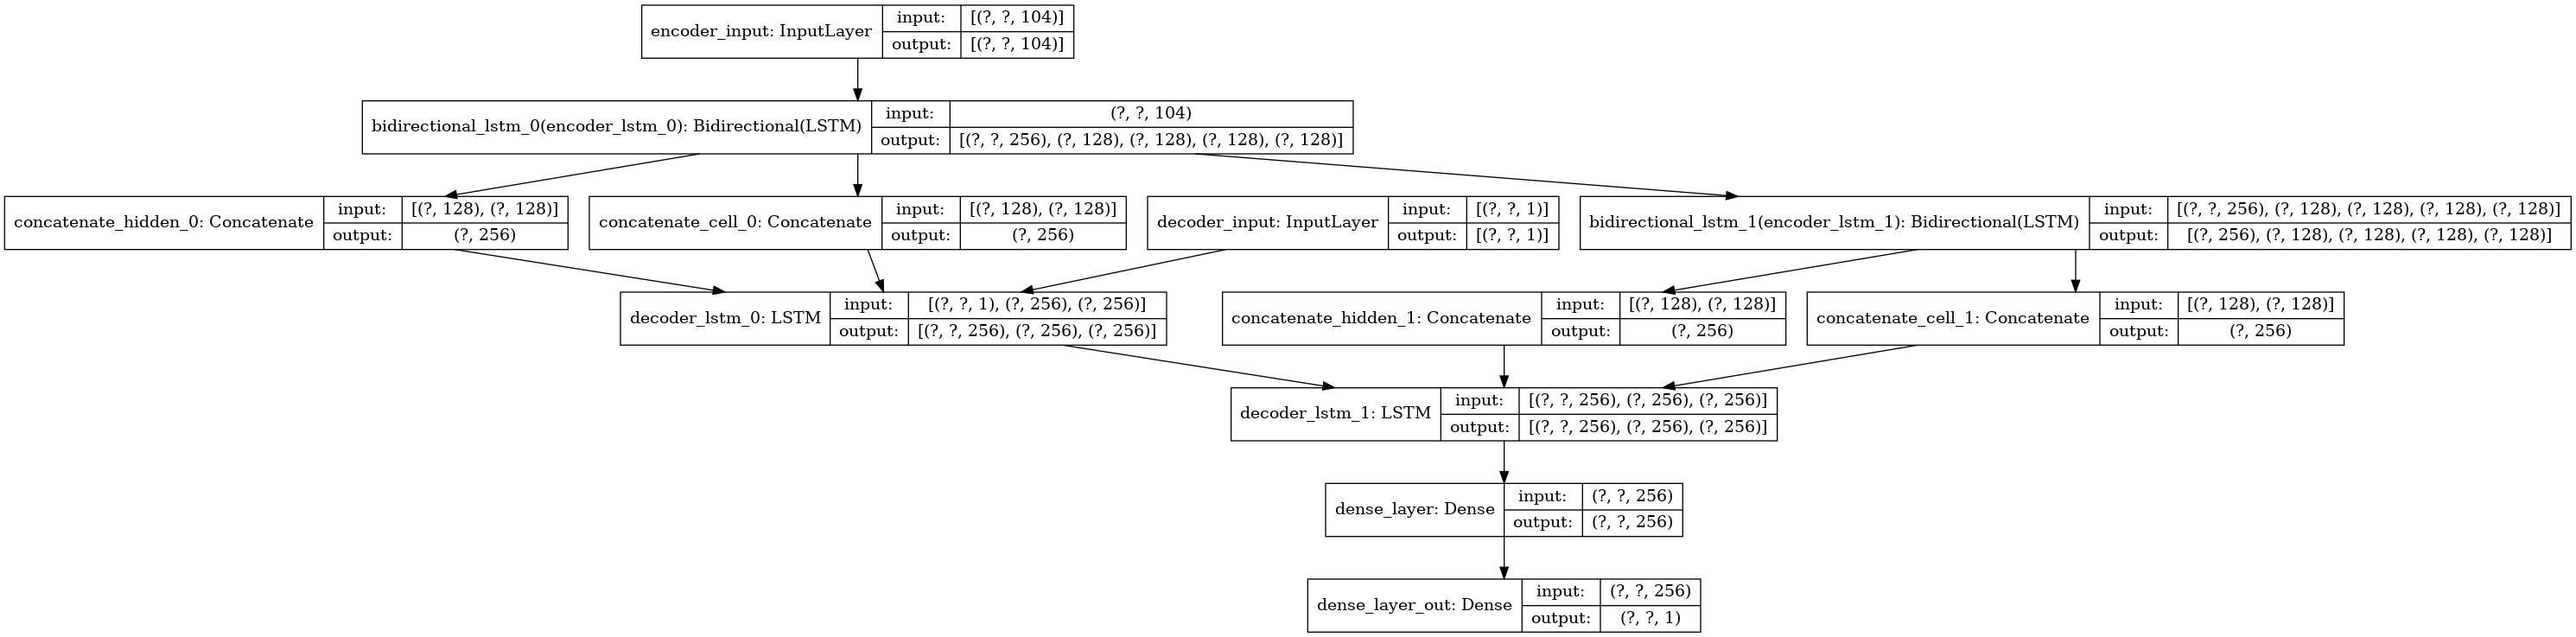

In [13]:
model_4 = create_model(lstm_layers=[cellsize,cellsize],n_in_features=n_in_features, n_out_features=n_out_features, bidirectional=True, activation_out='gelu')
model_4.summary()
keras.utils.plot_model(model_4, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96)

In [14]:
size_factor = 1
range_factor = 0.9
start_factor = 0.0
start_start_points = int(len(orderbook_df)*start_factor)    
end_start_points = int(len(orderbook_df)*range_factor)    
total_start_points = int((end_start_points-start_start_points)*size_factor)
orderbook_df.iloc[[start_start_points, end_start_points, len(orderbook_df) - 1]]

,Price,Volume,-0.000000500000,-0.000000601132,-0.000000722720,-0.000000868900,-0.000001044648,-0.000001255943,-0.000001509976,-0.000001815390,...,0.000952730359,0.001145433826,0.001377114352,0.001655655607,0.001990535853,0.002393150462,0.002877199687,0.003459154855,0.004158818856,0.005000000000
2018-09-01 00:00:05.311,0.060298,-0.008501,-1.0,-1.000000,0.366702,-0.243579,-0.378473,-0.368778,-0.359083,-0.349387,...,0.336916,0.389931,0.349751,0.318557,0.382015,0.357203,0.369771,0.450971,-1.0,-1.0
2019-12-30 07:32:40.686,0.089241,-0.016629,-1.0,-1.000000,0.438261,-0.081056,-0.071362,-0.061666,-0.051971,-0.042276,...,0.443463,0.364667,0.405794,0.448837,0.489292,0.447325,-0.637245,-1.000000,-1.0,-1.0
2020-02-26 02:48:03.293,0.215593,0.097036,-1.0,0.286805,-0.154753,-0.145058,-0.135363,-0.125668,-0.115973,-0.106278,...,0.367942,0.071101,0.413381,0.462598,0.415828,0.228115,-1.000000,-1.000000,-1.0,-1.0


In [15]:
rng = default_rng(0)

In [16]:
start_orderbook_ilocs = rng.choice(range(start_start_points, end_start_points), total_start_points, replace = False)
len(orderbook_df), len(start_orderbook_ilocs)

(1441026, 1296923)

In [17]:
def clean_start_ilocs(orderbook_df, start_orderbook_ilocs, timestep = 30, tolerance = 1.1):
    orderbook_df_index = orderbook_df.index
    start_orderbook_ts = orderbook_df.index[start_orderbook_ilocs]
    end_orderbook_ts = orderbook_df.index[start_orderbook_ilocs+input_seq_len+output_seq_len-1]
    start_orderbook_ilocs_clean = start_orderbook_ilocs[
        np.where((end_orderbook_ts - start_orderbook_ts).seconds < (input_seq_len+output_seq_len)*timestep*tolerance)
    ]
    return start_orderbook_ilocs_clean

start_orderbook_ilocs_clean = clean_start_ilocs(orderbook_df, start_orderbook_ilocs)
len(start_orderbook_ilocs_clean)

1170498

In [18]:
def get_training_slice(orderbook_df, loc, target_relative=False, relative_scale=1e2, scale_min_to_zero=True):
    data_slice = orderbook_df.iloc[np.r_[loc:loc+input_seq_len+output_seq_len]]
    if target_relative:
        target = relative_scale*(data_slice.to_numpy()[input_seq_len:,:1] - data_slice.to_numpy()[input_seq_len-1,0])
        target = np.maximum(np.minimum(target, 1),-1)
        return (data_slice.index,
            data_slice.to_numpy()[:input_seq_len], 
            target)
    else:
        if scale_min_to_zero:
            return (data_slice.index,
                (data_slice.to_numpy()[:input_seq_len]+1)/2,
                (data_slice.to_numpy()[input_seq_len:,:1]+1)/2)
        else:
            return (data_slice.index,
                data_slice.to_numpy()[:input_seq_len],
                data_slice.to_numpy()[input_seq_len:,:1])


get_training_slice(orderbook_df, start_orderbook_ilocs_clean[0])

(DatetimeIndex(['2019-09-26 09:42:51.914000', '2019-09-26 09:43:25.690000',
                '2019-09-26 09:43:57.644000', '2019-09-26 09:44:21.427000',
                '2019-09-26 09:44:52.087000', '2019-09-26 09:45:32.501000',
                '2019-09-26 09:46:02.504000', '2019-09-26 09:46:33.423000',
                '2019-09-26 09:47:05.917000', '2019-09-26 09:47:35.666000',
                '2019-09-26 09:48:07.420000', '2019-09-26 09:48:37.484000',
                '2019-09-26 09:49:07.201000', '2019-09-26 09:49:32.315000',
                '2019-09-26 09:50:09.689000', '2019-09-26 09:50:28.860000',
                '2019-09-26 09:51:06.287000', '2019-09-26 09:51:31.484000',
                '2019-09-26 09:52:09.615000', '2019-09-26 09:52:39.467000',
                '2019-09-26 09:52:59.237000', '2019-09-26 09:53:41.253000',
                '2019-09-26 09:54:05.957000', '2019-09-26 09:54:39.964000',
                '2019-09-26 09:55:01.964000', '2019-09-26 09:55:39.871000',
            

In [19]:
def get_training_sequences(
        orderbook_df, 
        input_seq_len, 
        output_seq_len, 
        size_factor = 1,
        range_factor = 0.9, 
        start_factor = 0,
        target_relative = False,
        relative_scale=1e2,
        rng = None):
    if not rng:
        rng = default_rng(0)
    
    start_start_points = int(len(orderbook_df)*start_factor)    
    end_start_points = int(len(orderbook_df)*range_factor)    
    total_start_points = int((end_start_points-start_start_points)*size_factor)
    
    

    while True:
        start_orderbook_ilocs = rng.choice(range(start_start_points, end_start_points), total_start_points, replace = False)
        start_orderbook_ilocs_clean = clean_start_ilocs(orderbook_df, start_orderbook_ilocs)
        def training_sequence():
            for loc in start_orderbook_ilocs_clean:
                yield get_training_slice(orderbook_df, loc, target_relative, relative_scale)
        yield (len(start_orderbook_ilocs_clean),training_sequence)


sample_sequences = get_training_sequences(
        orderbook_df, 
        input_seq_len, 
        output_seq_len,
        size_factor=10/len(orderbook_df))
for i, s in enumerate(sample_sequences):
    if i >= 2:
        break
    print(f'Sequence {i}: Size {s[0]}')
    for j, d in enumerate(s[1]()):
        print(f'Set {i}.{j}: Start {d[0][0]}, Types ({d[1].dtype},{d[2].dtype}) Shapes ({d[1].shape},{d[2].shape})')

Sequence 0: Size 6
Set 0.0: Start 2019-10-18 10:41:35.306000, Types (float64,float64) Shapes ((90, 104),(10, 1))
Set 0.1: Start 2019-05-14 07:35:50.147000, Types (float64,float64) Shapes ((90, 104),(10, 1))
Set 0.2: Start 2019-01-25 22:47:37.186000, Types (float64,float64) Shapes ((90, 104),(10, 1))
Set 0.3: Start 2019-01-08 10:05:11.990000, Types (float64,float64) Shapes ((90, 104),(10, 1))
Set 0.4: Start 2018-09-22 01:11:24.979000, Types (float64,float64) Shapes ((90, 104),(10, 1))
Set 0.5: Start 2019-07-11 16:31:50.725000, Types (float64,float64) Shapes ((90, 104),(10, 1))
Sequence 1: Size 8
Set 1.0: Start 2019-06-05 20:22:18.899000, Types (float64,float64) Shapes ((90, 104),(10, 1))
Set 1.1: Start 2019-07-09 12:14:21.960000, Types (float64,float64) Shapes ((90, 104),(10, 1))
Set 1.2: Start 2019-11-26 15:28:34.335000, Types (float64,float64) Shapes ((90, 104),(10, 1))
Set 1.3: Start 2019-07-26 19:16:52.424000, Types (float64,float64) Shapes ((90, 104),(10, 1))
Set 1.4: Start 2019-10

In [20]:
def get_training_sequence(orderbook_df, 
        input_seq_len, 
        output_seq_len, 
        size_factor = 1,
        range_factor = 0.9, 
        start_factor = 0,
        target_relative = False,
        relative_scale=1e2,
        rng = None):
    sequence_generator = get_training_sequences(
        orderbook_df, 
        input_seq_len, 
        output_seq_len,
        size_factor,
        range_factor, 
        start_factor,
        target_relative, 
        relative_scale,
        rng)
    for i, s in enumerate(sequence_generator):
        print(f'Input_sequence {i}: Size {s[0]}')            
        for j, d in enumerate(s[1]()):
            yield {"encoder_input": d[1], "decoder_input": np.zeros(d[2].shape)},d[2]

sample_sequence = get_training_sequence(
        orderbook_df, 
        input_seq_len, 
        output_seq_len,
        size_factor=10/len(orderbook_df))
for i, s in enumerate(sample_sequence):
    if i >= 20:
        break


sample_sequence = get_training_sequence(
        orderbook_df, 
        input_seq_len, 
        output_seq_len,
        target_relative = True,
        )
for i, s in enumerate(sample_sequence):
    if i >= 1:
        break
    print(s)


Input_sequence 0: Size 6
Input_sequence 1: Size 8
Input_sequence 2: Size 5
Input_sequence 3: Size 8
Input_sequence 0: Size 1170498
({'encoder_input': array([[ 0.16599695,  0.18977189, -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [ 0.16654016,  0.18983511, -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [ 0.16708251,  0.18985018, -1.        , ..., -1.        ,
        -1.        , -1.        ],
       ...,
       [ 0.16376151,  0.18598405, -1.        , ...,  0.31930513,
        -1.        , -1.        ],
       [ 0.16376151,  0.18594299, -1.        , ...,  0.45235183,
        -0.76361558, -1.        ],
       [ 0.1638023 ,  0.18589618, -1.        , ..., -1.        ,
        -1.        , -1.        ]]), 'decoder_input': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])}, array([[0.00863304],
       [0.02324506],
       [0.02324506],
       [0.02324506],
  

In [21]:
def get_training_dataset(orderbook_df, 
        input_seq_len, 
        output_seq_len, 
        size_factor = 1,
        range_factor = 0.9, 
        start_factor = 0,
        target_relative = False,
        relative_scale=1e2,
        rng = None):
    def generator():
        return  get_training_sequence(
        orderbook_df, 
        input_seq_len, 
        output_seq_len,
        size_factor,
        range_factor, 
        start_factor,
        target_relative, 
        relative_scale,
        rng)
    return tf.data.Dataset.from_generator(
        generator, 
        args=[], 
        output_types = ({"encoder_input": tf.float64, "decoder_input": tf.float64}, tf.float64), 
        output_shapes = (
            {
                "encoder_input": tf.TensorShape([input_seq_len, n_in_features]),
                "decoder_input": tf.TensorShape([output_seq_len, n_out_features])
            }, 
            tf.TensorShape([output_seq_len, n_out_features]))
    )

list(get_training_dataset(orderbook_df, 
        input_seq_len, 
        output_seq_len).batch(2).take(2).as_numpy_iterator())

Input_sequence 0: Size 1170498


[({'encoder_input': array([[[0.58299848, 0.59488595, 0.        , ..., 0.        ,
            0.        , 0.        ],
           [0.58327008, 0.59491756, 0.        , ..., 0.        ,
            0.        , 0.        ],
           [0.58354125, 0.59492509, 0.        , ..., 0.        ,
            0.        , 0.        ],
           ...,
           [0.58188075, 0.59299203, 0.        , ..., 0.65965257,
            0.        , 0.        ],
           [0.58188075, 0.5929715 , 0.        , ..., 0.72617592,
            0.11819221, 0.        ],
           [0.58190115, 0.59294809, 0.        , ..., 0.        ,
            0.        , 0.        ]],
   
          [[0.53858647, 0.70085552, 0.        , ..., 0.72016059,
            0.70885316, 0.72791522],
           [0.5376816 , 0.70099592, 0.        , ..., 0.67665034,
            0.73302127, 0.72037987],
           [0.53864422, 0.70115032, 0.        , ..., 0.72854702,
            0.72425305, 0.73508456],
           ...,
           [0.54482493, 0.70

In [22]:
checkpoint_filepath = f'/data/checkpoint/forecasting_{input_seq_len:04d}_{output_seq_len:04d}_3.{{epoch:06d}}-{{loss:.15f}}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='auto',
    save_best_only=False)

def train_model(model, training_dataset, epochs, steps_per_epoch,
    callbacks=[model_checkpoint_callback],
    total_loss = None,
    total_val_loss = None, 
    batch_size=128,
    initial_epoch=0):
    if not total_loss:
        total_loss = []
    if not total_val_loss:
        total_val_loss = []
    
    history = model.fit(training_dataset.batch(batch_size),
                            #batch_size=batch_size,
                            epochs=epochs,
                            initial_epoch=initial_epoch,
                            steps_per_epoch=steps_per_epoch,
                            callbacks=callbacks,                            
                            shuffle=False)
                            
    return history

In [28]:
model = model_2
model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96)
model.compile(optimizers.Adam(learning_rate=1e-5), loss = 'mean_squared_error')

training_dataset = get_training_dataset(orderbook_df, 
        input_seq_len, 
        output_seq_len,
        size_factor = 1,
        range_factor = 0.9,
        target_relative = False,
        relative_scale=1,
        )

start_time = time.time()
train_model(model, training_dataset, epochs=50, steps_per_epoch=1000, batch_size=batch_size, initial_epoch=0)
end_time = time.time()
run_time = (end_time - start_time)/60
run_time

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None, 104)]  0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
encoder_lstm_0 (LSTM)           [(None, None, 128),  119296      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_lstm_0 (LSTM)           [(None, None, 128),  66560       decoder_input[0][0]              
                                                                 encoder_lstm_0[0][1]  

InternalError:    Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 104, 128, 1, 90, 128, 128] 
	 [[{{node CudnnRNN}}]]
	 [[functional_3/encoder_lstm_0/PartitionedCall]] [Op:__inference_train_function_15974]

Function call stack:
train_function -> train_function -> train_function


In [ ]:
rng=default_rng()
seed = rng.integers(10000)

In [ ]:
test_set = get_training_dataset(orderbook_df, 
        input_seq_len, 
        output_seq_len,
        size_factor = 0.99,
        range_factor = 0.99,
        start_factor = 0.9,
        target_relative = False,
        relative_scale=1,
        rng=default_rng(seed)).batch(1).take(1)
test_data = next(test_set.as_numpy_iterator())

test_set = get_training_dataset(orderbook_df, 
        input_seq_len, 
        output_seq_len,
        size_factor = 0.99,
        range_factor = 0.99,
        start_factor = 0.9,
        target_relative = False,
        relative_scale=1,
        rng=default_rng(seed)).batch(1).take(1)
test_predict = model.predict(test_set)
price_prev = test_data[0]['encoder_input'][:,-1,0][0]
print(price_prev)
diff = np.concatenate((np.array([[0,0,0]]),
        np.array((test_data[1], test_predict, test_data[1]-test_predict)).reshape(3,-1).T))
print(np.sign(np.diff(diff[:2,:2].T)).reshape(-1))
print(diff)